In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import datetime
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
sns.set_style()

In [3]:
df = pd.read_csv("owid_covid_data.csv") #From our world in data
df_age = pd.read_excel("pop_france.xls")

In [4]:
df_age = df_age.drop([105,106])
df_age['age'] = df_age['Âge révolu'].apply(lambda x: 10 * (x//10) if x<90 else 90)

In [5]:
df_age_grouped = df_age.groupby('age').agg({'Ensemble':'sum'})

In [6]:
pop_par_age = df_age_grouped.to_dict()['Ensemble']
deces_par_age_prop = {0:0.000062,10:0.000077,20:0.000555,30:0.002268,40:0.006849,50:0.023832,60:0.070925,70:0.146092,80:0.429700,90:0.319641}
hospitalisation_par_age ={0:0.0012,10:0.0023,20:0.0072,30:0.0128,40:0.0254,50:0.0643,60:0.1414,70:0.2416,80:0.333,90:0.1707}
rea_par_age = {0:0.0012,10:0.0023,20:0.0054,30:0.0154,40:0.0447,50:0.1318,60:0.3098,70:0.3588,80:0.1168,90:0.0139}

In [7]:
df = pd.read_csv("owid_covid_data.csv")
country = 'France'
province = 0

df_country = df[(df['location']==country)]


In [8]:
start_date = "2020-10-03"
df_country = df_country[df_country.date >start_date]

In [9]:
def get_new_contamination(R_t, contaminated, population_tot, immunized_pop):
    tot_cantaminated_theo = R_t * contaminated.sum() 
    contaminated_share = (population_tot - immunized_pop) / np.sum(population_tot)
    new_contaminated = tot_cantaminated_theo * contaminated_share
    return new_contaminated

def get_elderly_vaccination(nb_vaccine, population_tot, immunized_pop):
    new_immunized = immunized_pop *0
    vaccinned = 0
    left_to_vaccine = population_tot - immunized_pop
    i = -1
    while vaccinned < nb_vaccine and -i <= len(immunized_pop):
        if left_to_vaccine[i] >=nb_vaccine - vaccinned:
            new_immunized[i] = nb_vaccine - vaccinned
            return new_immunized
        else:
            vaccinned += left_to_vaccine[i]
            new_immunized[i] = left_to_vaccine[i] 
            i = i-1
    return new_immunized

In [10]:
date_end = "2020-12-21"
# apres on a plus les donnees de ICU sur ourworld in data, d'ou le cutoff
ICU_periode_country = df_country[df_country.date<date_end].weekly_icu_admissions.sum()
hosp_period_country = df_country[df_country.date<date_end].weekly_hosp_admissions.sum()
Contamination_period_country = df_country[df_country.date<date_end].new_cases.sum()

In [11]:
mortalite_periode_country = df_country.new_deaths.sum()
Contamination_period_country_2 = df_country.new_cases.sum()

In [14]:
population_tot = np.array([pop_par_age[age] for age in [10 * i for i in range(10)]])
immunized_pop = population_tot * 0.1


In [15]:
# le fois deux est pour prendre en compte les contamination manquee. Ca donne un IFR de 0.8%
Contamination_period_per_age = 2* Contamination_period_country * population_tot / population_tot.sum()
Contamination_period_per_age_2 = 2* Contamination_period_country_2 * population_tot / population_tot.sum()
death_per_age = mortalite_periode_country * np.array([deces_par_age_prop[age] for age in [10 * i for i in range(10)]])
ICU_per_age = ICU_periode_country * np.array([rea_par_age[age] for age in [10 * i for i in range(10)]])
hosp_per_age = hosp_period_country * np.array([hospitalisation_par_age[age] for age in [10 * i for i in range(10)]])

In [16]:
mortality_per_contaminated = death_per_age / Contamination_period_per_age_2
ICU_per_contaminated = ICU_per_age / Contamination_period_per_age
hosp_per_contaminated = hosp_per_age /Contamination_period_per_age

In [17]:
current_contaminated = df_country[df_country.date>"2020-12-29"].new_cases.sum()*2

In [18]:
mortality_per_contaminated

array([4.44352527e-06, 5.12827549e-06, 4.07855888e-05, 1.49963413e-04,
       4.37558489e-04, 1.49055391e-03, 4.84279277e-03, 1.39347040e-02,
       7.16722445e-02, 1.89954482e-01])

In [19]:
nb_weeks = 26



In [20]:
Israel_vaccined = 0.15
UK_vaccined = 0.02
France_vaccined = 0.00
Israel_vaccins_par_semaines =  14000*7*65
UK_vaccins_par_semaines = 500000
France_vaccins_par_semaines_apres_transition = 700000

In [21]:
UK_vaccinations_list = [UK_vaccins_par_semaines * (1+i/2) if i <6 else UK_vaccins_par_semaines* 3 for i in range(nb_weeks)  ]
France_vaccinations_list = [100000 * i if i<6 else France_vaccins_par_semaines_apres_transition for i in range(nb_weeks)]
Israel_vaccinations_list = [Israel_vaccins_par_semaines for i in range(nb_weeks)]

In [44]:
sum(UK_vaccinations_list[:4])+0.02*65000000

4800000.0

In [22]:
R_t_scenario_1 = [1.3*1.15 if i >-1 else 1.15 for i in range(nb_weeks)]


In [23]:
contaminated_list = []
immunized_list = []
dead_list = []
icu_list = []
hosp_list = []
contaminated_list_per_age = []
immunized_list_per_age = []
dead_list_per_age = []
icu_list_per_age = []
hosp_list_per_age = []
day_list = []
vaccinated_list = []
vaccinated_list_per_age = []
#il y a 15% d immunise, donc je rescale le RT par 1.15 pour avoir bien un R_t observe de 1.15. 
vaccinne_speed =Israel_vaccinations_list
date = datetime.datetime(2021,1,6)
current_contaminated_per_age = current_contaminated * population_tot / population_tot.sum()
current_contaminated = df_country[df_country.date>"2020-12-29"].new_cases.sum()*2
current_immunized = population_tot*0.15 + get_elderly_vaccination(Israel_vaccined*population_tot.sum(), population_tot, population_tot*0.15)
for i in range(nb_weeks):
    date = date + datetime.timedelta(days=7)
    R_t = R_t_scenario_1[i]
    nb_vaccine = vaccinne_speed[i]
    new_contaminated = get_new_contamination(R_t, current_contaminated_per_age, population_tot, current_immunized)
    new_vaccinated = get_elderly_vaccination(nb_vaccine, population_tot, current_immunized)
    new_immunized = np.clip(current_immunized + new_contaminated + new_vaccinated,0,population_tot)
    new_dead = new_contaminated * mortality_per_contaminated
    new_hospital = new_contaminated * hosp_per_contaminated
    new_ICU = new_contaminated * ICU_per_contaminated
    
    current_contaminated_per_age= new_contaminated
    current_immunized = new_immunized
    
    contaminated_list.append(new_contaminated.sum())
    immunized_list.append(new_immunized.sum())
    dead_list.append(new_dead.sum())
    hosp_list.append(new_hospital.sum())
    icu_list.append(new_ICU.sum())
    vaccinated_list.append(new_vaccinated.sum())
    
    contaminated_list_per_age.append(new_contaminated)
    immunized_list_per_age.append(new_immunized)
    dead_list_per_age.append(new_dead)
    icu_list_per_age.append(new_ICU)
    hosp_list_per_age.append(new_hospital)
    day_list.append(date)
    vaccinated_list_per_age.append(new_vaccinated)

In [24]:
df_modelise = pd.DataFrame(dead_list)
df_modelise.columns = ['morts_par_semaine_scenario_Israel']

In [25]:
df_modelise['date'] = day_list
df_modelise['reanimations_par_semaine_scenario_Israel'] =  icu_list
df_modelise['hospitalisations_par_semaine_scenario_Israel'] =  hosp_list
df_modelise['contaminations_par_semaine_scenario_Israel'] =  contaminated_list
df_modelise['vaccined_par_semaine_scenario_Israel'] =  vaccinated_list
df_modelise['immunized_par_semaine_scenario_Israel'] =  immunized_list

In [26]:
contaminated_list = []
immunized_list = []
dead_list = []
icu_list = []
hosp_list = []
contaminated_list_per_age = []
immunized_list_per_age = []
dead_list_per_age = []
icu_list_per_age = []
hosp_list_per_age = []
day_list = []
vaccinated_list = []
vaccinated_list_per_age = []


vaccinne_speed =UK_vaccinations_list
date = datetime.datetime(2021,1,6)
current_contaminated_per_age = current_contaminated * population_tot / population_tot.sum()
current_contaminated = df_country[df_country.date>"2020-12-29"].new_cases.sum()*2
current_immunized = population_tot*0.15 + get_elderly_vaccination(UK_vaccined*population_tot.sum(), population_tot,  population_tot*0.15)
for i in range(nb_weeks):
    date = date + datetime.timedelta(days=7)
    R_t = R_t_scenario_1[i]
    nb_vaccine = vaccinne_speed[i]
    new_contaminated = get_new_contamination(R_t, current_contaminated_per_age, population_tot, current_immunized)
    new_vaccinated = get_elderly_vaccination(nb_vaccine, population_tot, current_immunized)
    new_immunized = np.clip(current_immunized + new_contaminated + new_vaccinated,0,population_tot)
    new_dead = new_contaminated * mortality_per_contaminated
    new_hospital = new_contaminated * hosp_per_contaminated
    new_ICU = new_contaminated * ICU_per_contaminated
    
    current_contaminated_per_age= new_contaminated
    current_immunized = new_immunized
    
    contaminated_list.append(new_contaminated.sum())
    immunized_list.append(new_immunized.sum())
    dead_list.append(new_dead.sum())
    hosp_list.append(new_hospital.sum())
    icu_list.append(new_ICU.sum())
    vaccinated_list.append(new_vaccinated.sum())
    
    contaminated_list_per_age.append(new_contaminated)
    immunized_list_per_age.append(new_immunized)
    dead_list_per_age.append(new_dead)
    icu_list_per_age.append(new_ICU)
    hosp_list_per_age.append(new_hospital)
    day_list.append(date)
    vaccinated_list_per_age.append(new_vaccinated)

In [27]:
df_modelise['morts_par_semaine_scenario_UK'] = dead_list
df_modelise['reanimations_par_semaine_scenario_UK'] =  icu_list
df_modelise['hospitalisations_par_semaine_scenario_UK'] =  hosp_list
df_modelise['contaminations_par_semaine_scenario_UK'] =  contaminated_list
df_modelise['vaccined_par_semaine_scenario_UK'] =  vaccinated_list
df_modelise['immunized_par_semaine_scenario_UK'] =  immunized_list

In [28]:
contaminated_list = []
immunized_list = []
dead_list = []
icu_list = []
hosp_list = []
contaminated_list_per_age = []
immunized_list_per_age = []
dead_list_per_age = []
icu_list_per_age = []
hosp_list_per_age = []
day_list = []
vaccinated_list = []
vaccinated_list_per_age = []

vaccinne_speed = France_vaccinations_list
date = datetime.datetime(2021,1,6)
current_contaminated_per_age = current_contaminated * population_tot / population_tot.sum()
current_contaminated = df_country[df_country.date>"2020-12-29"].new_cases.sum()*2
current_immunized = population_tot*0.15 + get_elderly_vaccination(France_vaccined*population_tot.sum(), population_tot, population_tot*0.15)
for i in range(nb_weeks):
    date = date + datetime.timedelta(days=7)
    R_t = R_t_scenario_1[i]
    nb_vaccine = vaccinne_speed[i]
    new_contaminated = get_new_contamination(R_t, current_contaminated_per_age, population_tot, current_immunized)
    new_vaccinated = get_elderly_vaccination(nb_vaccine, population_tot, current_immunized)
    new_immunized = np.clip(current_immunized + new_contaminated + new_vaccinated,0,population_tot)
    new_dead = new_contaminated * mortality_per_contaminated
    new_hospital = new_contaminated * hosp_per_contaminated
    new_ICU = new_contaminated * ICU_per_contaminated
    
    current_contaminated_per_age= new_contaminated
    current_immunized = new_immunized
    
    contaminated_list.append(new_contaminated.sum())
    immunized_list.append(new_immunized.sum())
    dead_list.append(new_dead.sum())
    hosp_list.append(new_hospital.sum())
    icu_list.append(new_ICU.sum())
    vaccinated_list.append(new_vaccinated.sum())
    
    contaminated_list_per_age.append(new_contaminated)
    immunized_list_per_age.append(new_immunized)
    dead_list_per_age.append(new_dead)
    icu_list_per_age.append(new_ICU)
    hosp_list_per_age.append(new_hospital)
    day_list.append(date)
    vaccinated_list_per_age.append(new_vaccinated)

In [29]:
df_modelise['morts_par_semaine_scenario_France'] = dead_list
df_modelise['reanimations_par_semaine_scenario_France'] =  icu_list
df_modelise['hospitalisations_par_semaine_scenario_France'] =  hosp_list
df_modelise['contaminations_par_semaine_scenario_France'] =  contaminated_list
df_modelise['vaccined_par_semaine_scenario_France'] =  vaccinated_list
df_modelise['immunized_par_semaine_scenario_France'] =  immunized_list

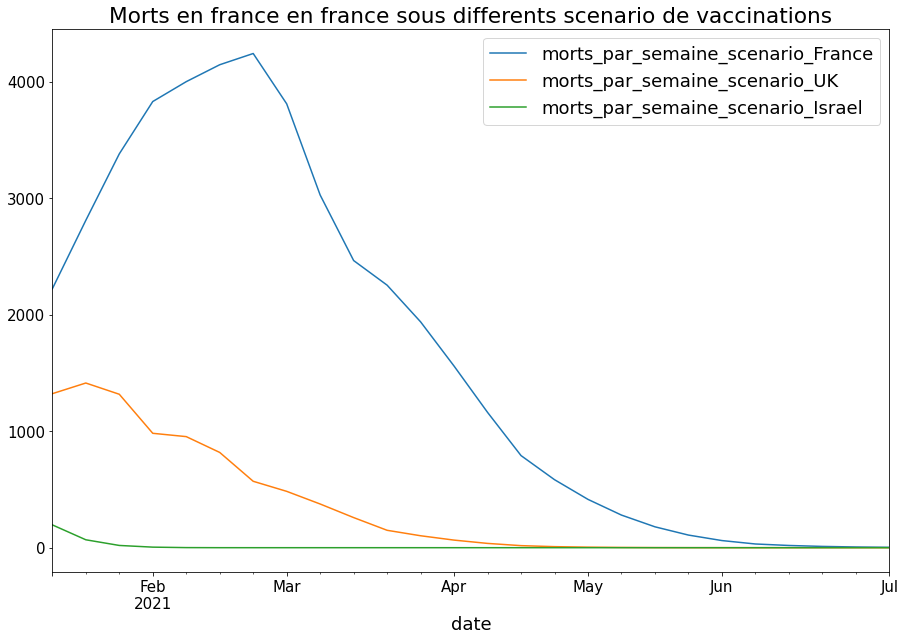

In [30]:
plt.rcParams.update({'font.size': 18}) # must set in top

df_modelise.plot(x='date', y=['morts_par_semaine_scenario_France','morts_par_semaine_scenario_UK','morts_par_semaine_scenario_Israel'],
                figsize = (15,10),title = 'Morts en france en france sous differents scenario de vaccinations', fontsize=15)


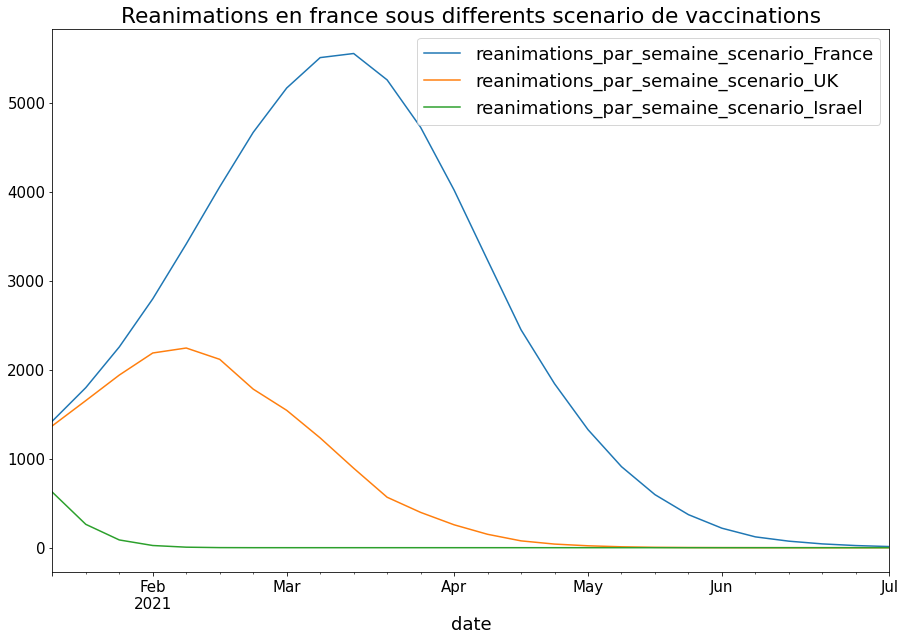

In [31]:
plt.rcParams.update({'font.size': 18}) # must set in top

df_modelise.plot(x='date', y=['reanimations_par_semaine_scenario_France','reanimations_par_semaine_scenario_UK','reanimations_par_semaine_scenario_Israel'],
                figsize = (15,10),title = 'Reanimations en france sous differents scenario de vaccinations', fontsize=15)


In [32]:
1/1.15

0.8695652173913044

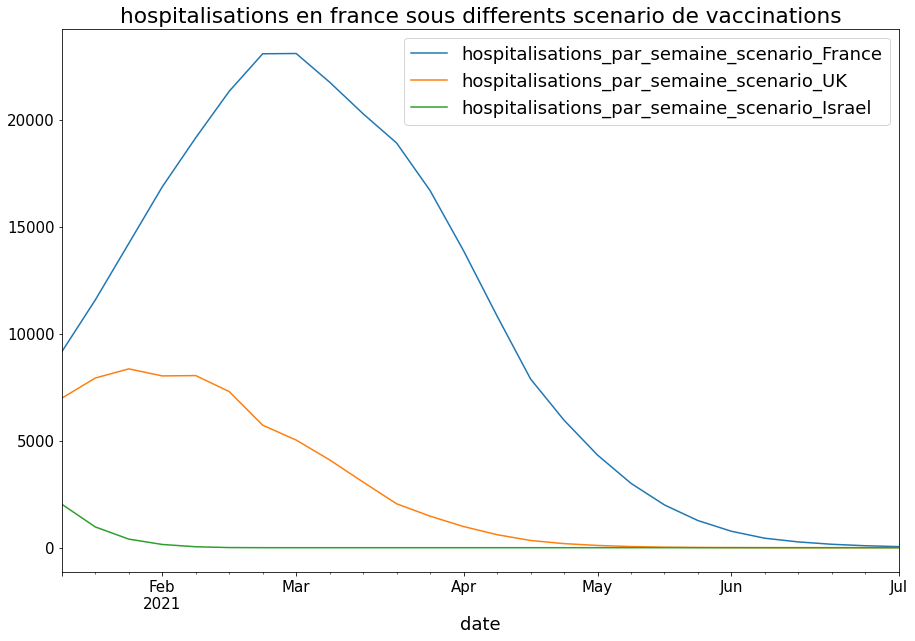

In [33]:
plt.rcParams.update({'font.size': 18}) # must set in top

df_modelise.plot(x='date', y=['hospitalisations_par_semaine_scenario_France','hospitalisations_par_semaine_scenario_UK','hospitalisations_par_semaine_scenario_Israel'],
                figsize = (15,10),title = 'hospitalisations en france sous differents scenario de vaccinations', fontsize=15)


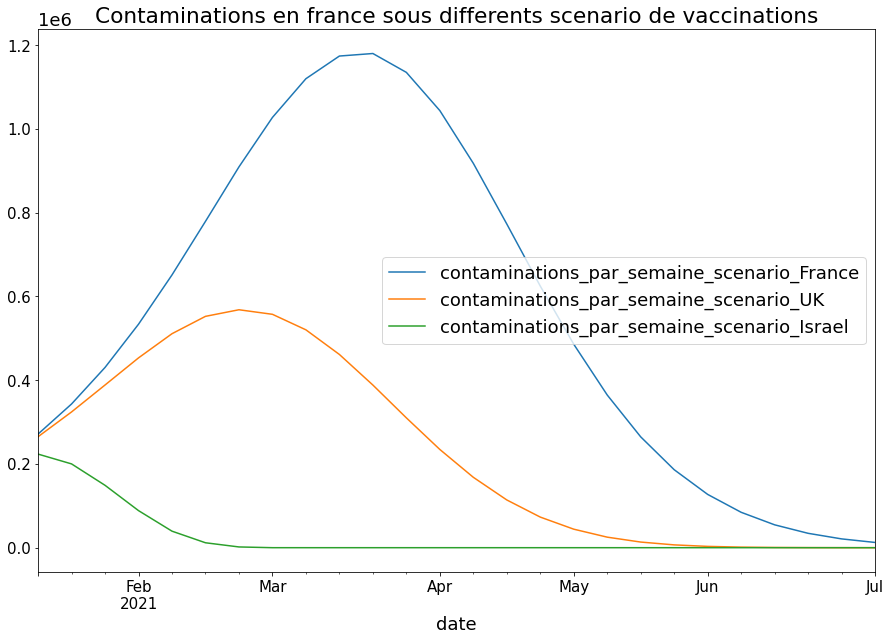

In [34]:
plt.rcParams.update({'font.size': 18}) # must set in top

df_modelise.plot(x='date', y=['contaminations_par_semaine_scenario_France','contaminations_par_semaine_scenario_UK','contaminations_par_semaine_scenario_Israel'],
                figsize = (15,10),title = 'Contaminations en france sous differents scenario de vaccinations', fontsize=15)


In [35]:
population_tot / population_tot.sum()

array([0.1142292 , 0.12292281, 0.11140363, 0.1238143 , 0.12814573,
       0.13089585, 0.11989927, 0.08583053, 0.04908259, 0.01377609])

In [36]:
df_modelise[['morts_par_semaine_scenario_Israel','morts_par_semaine_scenario_UK','morts_par_semaine_scenario_France']].sum()

morts_par_semaine_scenario_Israel      288.546925
morts_par_semaine_scenario_UK         8879.422728
morts_par_semaine_scenario_France    43325.246878
dtype: float64

In [37]:
df_modelise[['reanimations_par_semaine_scenario_Israel','reanimations_par_semaine_scenario_UK','reanimations_par_semaine_scenario_France']].sum()

reanimations_par_semaine_scenario_Israel     1004.940392
reanimations_par_semaine_scenario_UK        18493.306238
reanimations_par_semaine_scenario_France    61865.372463
dtype: float64